### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 96       #  (submerged pipe weight) [kg/m]
N = 100        # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 84.6 # [m]
B = 12
H = 13
Xg = L/2 # [m]
mn = 27_162_500 #123_000_000   # mass of the vessel, [kg]

In [8]:
lx, ly, lz = L/2, B/2, H/2

In [9]:
vessel_mass = mn/L # mass over length of the vessel

In [10]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [11]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [12]:
Ar=np.pi*((d0/2)**2-(dI/2)**2)   

In [13]:
E = 210e9

In [14]:
h = 100 # water depth

In [15]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [16]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [17]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [18]:
# Constants: 

In [19]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [20]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [21]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [22]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [23]:
# for testing:

In [24]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [25]:
φ

array([0.49624074, 0.96143571, 0.3821409 , 0.09232058, 0.14645568,
       0.30175782, 0.51200172, 0.45747274, 0.14670671, 0.44835419,
       0.02598438, 0.13196471, 0.47188473, 0.811386  , 0.93960845,
       0.16552823, 0.93009544, 0.65526799, 0.5758762 , 0.31362845,
       0.5667192 , 0.70267552, 0.31695906, 0.09971591, 0.4753143 ,
       0.01013621, 0.43342466, 0.69747046, 0.62028439, 0.66090418,
       0.89662743, 0.99318324, 0.49346488, 0.6971362 , 0.51192245,
       0.50174233, 0.6601569 , 0.15935712, 0.78982661, 0.3285356 ,
       0.87163219, 0.96457433, 0.52863343, 0.36911053, 0.75948831,
       0.44028079, 0.9682421 , 0.50008244, 0.602452  , 0.53952168,
       0.15815248, 0.5151063 , 0.09674041, 0.37217814, 0.74128469,
       0.51457942, 0.43902559, 0.90432035, 0.43082503, 0.85543276,
       0.63703395, 0.9730172 , 0.8670794 , 0.75788999, 0.07137983,
       0.71325564, 0.08275368, 0.60921371, 0.31337901, 0.68139648,
       0.90266062, 0.329256  , 0.43430886, 0.74128087, 0.43585

In [26]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [27]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [28]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [29]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

### Main functions:

In [30]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [31]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [32]:
Π(φ,θ,ψ)

array([[[ 0.78508581,  0.        ,  0.54467571],
        [ 0.        ,  1.        , -0.4761231 ],
        [-0.61938702,  0.        ,  0.69038769]],

       [[ 0.9277988 ,  0.        ,  0.21353037],
        [ 0.        ,  1.        , -0.82001413],
        [-0.37308095,  0.        ,  0.5310194 ]],

       [[ 0.56648218,  0.        ,  0.76463222],
        [ 0.        ,  1.        , -0.3729078 ],
        [-0.82407399,  0.        ,  0.52562092]],

       [[ 0.97258712,  0.        ,  0.23154852],
        [ 0.        ,  1.        , -0.09218949],
        [-0.23253879,  0.        ,  0.96844534]],

       [[ 0.78526146,  0.        ,  0.61253586],
        [ 0.        ,  1.        , -0.14593268],
        [-0.61916431,  0.        ,  0.77685486]],

       [[ 0.99947166,  0.        ,  0.0310336 ],
        [ 0.        ,  1.        , -0.29719906],
        [-0.03250219,  0.        ,  0.95431108]],

       [[ 0.81216506,  0.        ,  0.50861221],
        [ 0.        ,  1.        , -0.48992325],
        

In [33]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [34]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 8.33896313e-01,  1.21295248e-02,  4.32326737e-01],
       [ 8.54203073e-01, -2.79559038e-01,  2.09456333e-01],
       [ 6.40857479e-01, -4.67207695e-02,  3.24771156e-01],
       [ 5.65024409e-01,  4.21794424e-01,  7.98272602e-01],
       [ 5.07418801e-01,  9.08188184e-01, -3.33318383e-02],
       [ 8.35800860e-01,  5.94911224e-01,  7.13715728e-02],
       [ 1.05113115e+00,  8.51419061e-02,  2.69590790e-01],
       [ 9.86242529e-01,  2.67513952e-01,  1.49534799e-01],
       [ 7.83109353e-01,  8.74004337e-01,  4.09053576e-01],
       [ 5.96764943e-01,  2.71363055e-01,  1.82413388e-01],
       [ 4.53102991e-01,  2.87704689e-02,  3.52395864e-01],
       [ 6.98546918e-01,  8.61081562e-01,  6.47023566e-01],
       [ 4.22066327e-01, -1.77108944e-01,  1.97160200e-01],
       [ 5.32989677e-01,  6.70118308e-01, -1.22275984e-02],
       [ 4.78607617e-01, -6.94152579e-01,  3.28128973e-01],
       [ 8.68462915e-01,  2.45676806e-01, -5.00977596e-01],
       [ 4.91886584e-01,  2.51244445e-01

In [35]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [36]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 1.49428701,  0.02833202,  0.69433064],
       [ 1.94043289, -0.08265244,  0.39227504],
       [ 0.97644338,  0.84679247,  0.02371142],
       [ 1.12096549,  0.88763727,  1.41360039],
       [ 1.14381324,  0.90506524,  0.40596552],
       [ 1.35478173,  0.60636556, -0.04137044],
       [ 1.40836565,  0.23010759,  0.55752829],
       [ 1.69834781, -0.12320767,  0.45176911],
       [ 1.70079489,  0.69020936,  0.52214774],
       [ 1.18974809,  0.29042637,  0.11525497],
       [ 1.18694851,  0.74399996,  0.45928227],
       [ 1.87826074,  0.96950197,  0.5731936 ],
       [ 1.23529211, -0.33914009,  0.30545512],
       [ 1.11905036,  1.37832918, -0.42701779],
       [ 0.56547153, -0.17440181,  1.16592088],
       [ 1.85997785,  0.87548015,  0.01845289],
       [ 0.89572485,  0.32997641,  0.2007984 ],
       [ 1.26912591,  0.27836353, -0.28343815],
       [ 1.11611452,  0.35812349,  0.43464383],
       [ 0.92643002,  0.83970249,  0.68749769],
       [ 0.94848182,  0.54871215,  0.183

In [37]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [38]:
phi(x,y,z)

array([[0.95795323, 0.61464404, 0.7026103 ],
       [0.81162342, 0.75775468, 0.35459016],
       [0.23503065, 0.49890438, 0.65788622],
       [0.42635743, 0.57672864, 0.65809843],
       [0.4580753 , 0.64449064, 0.77691043],
       [0.83903737, 0.1736177 , 0.30487485],
       [0.13186889, 0.20872955, 0.63455668],
       [0.17624133, 0.75903397, 0.16578047],
       [0.20938052, 0.78278583, 0.68653512],
       [0.40049589, 0.08498101, 0.60477124],
       [0.82561752, 0.84484413, 0.24252653],
       [0.48953428, 0.71299317, 0.91103506],
       [0.43433611, 0.40242125, 0.41231937],
       [0.67721834, 0.36748489, 0.27645723],
       [0.74295134, 0.66718499, 0.322621  ],
       [0.4507434 , 0.07599493, 0.70816502],
       [0.99371537, 0.57636936, 0.22514314],
       [0.46198129, 0.18499512, 0.99570568],
       [0.49764308, 0.28696952, 0.58568638],
       [0.20947416, 0.01114017, 0.0270198 ],
       [0.27559532, 0.99447977, 0.6034317 ],
       [0.63513676, 0.73180312, 0.63818393],
       [0.

In [39]:
theta(φ,θ,ψ)

array([[0.49624074, 0.66796168, 0.89154703],
       [0.96143571, 0.38232752, 0.07767684],
       [0.3821409 , 0.96856558, 0.40813657],
       [0.09232058, 0.23468722, 0.39258886],
       [0.14645568, 0.66767804, 0.48578194],
       [0.30175782, 0.03250792, 0.28802992],
       [0.51200172, 0.62294282, 0.27069304],
       [0.45747274, 0.82476038, 0.22363871],
       [0.14670671, 0.03199353, 0.03551181],
       [0.44835419, 0.08105783, 0.84261097],
       [0.02598438, 0.38476973, 0.28793152],
       [0.13196471, 0.52471925, 0.8940935 ],
       [0.47188473, 0.9679276 , 0.37420066],
       [0.811386  , 0.40532735, 0.06757278],
       [0.93960845, 0.87814246, 0.78048088],
       [0.16552823, 0.70260602, 0.46536369],
       [0.93009544, 0.50270949, 0.37459604],
       [0.65526799, 0.75317186, 0.74374857],
       [0.5758762 , 0.34707519, 0.80505777],
       [0.31362845, 0.04099743, 0.25342003],
       [0.5667192 , 0.64536239, 0.10152284],
       [0.70267552, 0.18981229, 0.37241408],
       [0.

In [40]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [41]:
ω(x,y,z)

array([[ 1.01568096e+00,  3.98975741e-02, -2.22248345e-01],
       [ 7.57296715e-01,  5.00533007e-01, -3.80533124e-01],
       [ 5.12502807e-01,  3.45700578e-01,  4.49358605e-01],
       [ 6.84120501e-01,  3.04567382e-01,  2.69780634e-01],
       [ 7.84828551e-01,  3.00923246e-01,  2.81830417e-01],
       [ 8.61613940e-01, -5.32092672e-02,  5.57075294e-02],
       [ 2.59356104e-01,  1.25293576e-01,  5.88068388e-01],
       [ 2.40189530e-01,  7.29967614e-01, -2.88212283e-03],
       [ 6.22049829e-01,  6.40086763e-01,  3.28422998e-01],
       [ 4.46320810e-01, -1.50804201e-01,  5.20911007e-01],
       [ 6.71077260e-01,  6.66595217e-01, -5.08277525e-01],
       [ 8.96207768e-01,  2.84610895e-01,  2.87973885e-01],
       [ 5.46129294e-01,  2.28913862e-01,  1.74049129e-01],
       [ 7.09407092e-01,  1.94249151e-01, -4.22401465e-02],
       [ 7.30660703e-01,  4.48943347e-01, -2.73068726e-01],
       [ 4.97837743e-01, -2.32506407e-01,  6.01374941e-01],
       [ 9.00119743e-01,  3.87686181e-01

In [42]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [43]:
Ret(φ,θ,ψ)

array([[[ 0.72264687, -0.42557005,  0.54467571],
        [ 0.68419575,  0.55243368, -0.4761231 ],
        [-0.09827348,  0.71673368,  0.69038769]],

       [[ 0.94874109,  0.23301314,  0.21353037],
        [ 0.04441312,  0.57061747, -0.82001413],
        [-0.31291823,  0.78746465,  0.5310194 ]],

       [[ 0.64192117,  0.05722573,  0.76463222],
        [ 0.36827064,  0.85165516, -0.3729078 ],
        [-0.67254289,  0.52096901,  0.52562092]],

       [[ 0.906796  , -0.35228725,  0.23154852],
        [ 0.38095237,  0.91998717, -0.09218949],
        [-0.18054448,  0.17180602,  0.96844534]],

       [[ 0.73660202, -0.28673556,  0.61253586],
        [ 0.46190159,  0.87484317, -0.14593268],
        [-0.49402873,  0.3904256 ,  0.77685486]],

       [[ 0.96104274, -0.27465208,  0.0310336 ],
        [ 0.27122859,  0.91548226, -0.29719906],
        [ 0.05321563,  0.2940382 ,  0.95431108]],

       [[ 0.85902275,  0.058254  ,  0.50861221],
        [ 0.23310951,  0.84002093, -0.48992325],
        

In [44]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [45]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[-1.83329190e-02, -3.19730038e-01,  3.04695561e-01],
       [ 3.53529332e-01, -5.79828636e-01,  4.29891166e-01],
       [ 5.87161078e-01, -3.71320095e-01,  7.18245336e-02],
       [-7.62624294e-02,  3.40344726e-02,  1.95812624e-02],
       [ 2.78873010e-01, -1.89194869e-01, -7.47900353e-03],
       [-6.22066338e-02,  1.27722301e-01,  9.84628223e-02],
       [ 3.33485077e-01, -3.65349959e-01,  5.08749301e-02],
       [ 2.71992612e-01, -1.11111935e-01,  2.19575887e-01],
       [-5.41117251e-03, -9.50700148e-02,  1.10048929e-01],
       [-2.33107395e-01, -1.88736560e-02,  1.57022108e-01],
       [-1.25652928e-01,  1.80170483e-01, -1.99873869e-01],
       [-1.28927904e-01, -1.65419609e-01,  1.98738433e-01],
       [ 4.09328014e-01, -3.10264011e-01, -1.28369189e-01],
       [ 2.00371166e-01, -3.98929027e-01,  3.94468376e-02],
       [ 3.66225666e-01, -6.26629091e-01,  4.52511366e-01],
       [ 4.24767605e-01, -1.89830558e-01, -2.49991220e-01],
       [ 1.90761380e-01, -4.58110179e-01

In [46]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[ 1.12388276e-02, -6.27362417e-01,  4.63774624e-01],
       [ 1.46118409e-01, -3.75780967e-01,  4.10411743e-02],
       [ 4.30421385e-01, -2.54082815e-01,  1.99968001e-01],
       [-6.26320004e-03, -3.78197145e-02,  2.40812378e-02],
       [ 9.84835604e-02, -1.58427431e-01,  1.88057713e-01],
       [-2.39093734e-02, -9.45930855e-03,  2.61165325e-02],
       [ 1.99419916e-01, -2.04645881e-01,  9.37569068e-02],
       [ 3.27127453e-01, -1.93786395e-01,  4.54994924e-02],
       [-2.14260319e-05, -7.84317302e-04,  7.95127728e-04],
       [-2.97874595e-01, -1.05299395e-01,  1.68629021e-01],
       [ 9.73361947e-03, -3.13631359e-02,  4.10328941e-02],
       [-3.85037016e-03, -4.06607113e-01,  2.39194995e-01],
       [ 4.91853370e-01, -2.97098321e-01,  1.48240172e-01],
       [ 1.36430919e-01, -2.76534125e-01,  2.05512733e-02],
       [ 5.70287462e-01, -1.14799203e+00,  6.05080327e-01],
       [ 1.20320318e-01, -1.56541669e-01,  1.93549070e-01],
       [ 2.02455886e-01, -5.80015194e-01

In [47]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
#     t1=np.einsum('ijk,kp->ijp',RET, np.array([0,0,1]).reshape(3,1)).squeeze()
    return np.einsum('ijk,ik->ij', A, B 
#                      - t1
                    )

In [48]:
ne(x, y, z, φ, θ, ψ)

array([[-1.83329190e+07, -3.19730038e+08,  3.04695561e+08],
       [ 3.53529332e+08, -5.79828636e+08,  4.29891166e+08],
       [ 5.87161078e+08, -3.71320095e+08,  7.18245336e+07],
       [-7.62624294e+07,  3.40344726e+07,  1.95812624e+07],
       [ 2.78873010e+08, -1.89194869e+08, -7.47900353e+06],
       [-6.22066338e+07,  1.27722301e+08,  9.84628223e+07],
       [ 3.33485077e+08, -3.65349959e+08,  5.08749301e+07],
       [ 2.71992612e+08, -1.11111935e+08,  2.19575887e+08],
       [-5.41117251e+06, -9.50700148e+07,  1.10048929e+08],
       [-2.33107395e+08, -1.88736560e+07,  1.57022108e+08],
       [-1.25652928e+08,  1.80170483e+08, -1.99873869e+08],
       [-1.28927904e+08, -1.65419609e+08,  1.98738433e+08],
       [ 4.09328014e+08, -3.10264011e+08, -1.28369189e+08],
       [ 2.00371166e+08, -3.98929027e+08,  3.94468376e+07],
       [ 3.66225666e+08, -6.26629091e+08,  4.52511366e+08],
       [ 4.24767605e+08, -1.89830558e+08, -2.49991220e+08],
       [ 1.90761380e+08, -4.58110179e+08

In [49]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[ 1.72710094e+08, -2.72317461e+08, -2.75362698e+08],
       [-4.70871255e+07, -5.02827649e+08, -6.39480899e+08],
       [ 2.13594651e+07, -9.69063735e+07, -6.75601051e+08],
       [-8.32250387e+06, -3.08960309e+07,  2.12874811e+07],
       [ 4.97791648e+07,  8.30390037e+07, -2.44482825e+08],
       [-3.90821886e+07, -4.70649858e+07,  3.63596817e+07],
       [-1.41693810e+07, -6.38627723e+07, -3.65739748e+08],
       [ 1.37210603e+08, -1.54871259e+08, -2.48334716e+08],
       [ 5.84155475e+06, -1.64249274e+07, -1.39020747e+07],
       [-3.10265452e+07, -2.47785943e+08, -7.58437389e+07],
       [-1.21720511e+08, -5.88962841e+06,  7.12119172e+07],
       [ 1.96854812e+08, -2.01316150e+08, -3.98592281e+07],
       [-1.64379618e+08, -1.21568702e+07, -4.94770933e+08],
       [-9.65240495e+07, -8.56780843e+07, -3.76173081e+08],
       [-1.56565233e+08, -5.88998076e+08, -6.88922192e+08],
       [-1.10285191e+08,  2.09087856e+08, -3.46159520e+08],
       [-4.84449816e+07, -3.53355449e+08

In [50]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [51]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 8.75195579e+10,  2.43475540e+10,  3.08148018e+10],
       [ 9.08605259e+10,  3.18631416e+10, -3.17445440e+10],
       [ 5.28550381e+10,  8.16368270e+10, -1.00387255e+10],
       [ 1.80693177e+10,  1.98494649e+10,  3.58732742e+10],
       [ 4.12564859e+10,  5.96786582e+10,  2.86701928e+10],
       [ 3.10536995e+10, -5.30943019e+09,  2.65062355e+10],
       [ 5.53507687e+10,  4.90324002e+10, -1.07060585e+10],
       [ 4.57850555e+10,  7.25983157e+10, -1.99778653e+10],
       [ 1.47755389e+10,  2.68023797e+09,  3.04194923e+09],
       [ 5.08364235e+10, -2.84199680e+10,  7.20532776e+10],
       [ 1.32121907e+10,  3.77288854e+10,  2.57036153e+10],
       [ 5.58230359e+10,  4.07072618e+10,  7.00967909e+10],
       [ 5.42110156e+10,  7.97828760e+10, -1.99710521e+10],
       [ 7.63987229e+10,  3.56320725e+10, -2.77191600e+10],
       [ 9.54446449e+10,  2.48039090e+10, -4.28971053e+10],
       [ 4.22936275e+10,  6.25926477e+10,  2.43327173e+10],
       [ 9.22908199e+10,  2.02404460e+10

In [52]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[ 2.86102295e-06, -1.18449819e-05,  0.00000000e+00],
       [ 1.90734863e-06, -3.50075084e-06,  3.81469727e-06],
       [ 9.53674316e-07,  7.89191266e-07,  7.62939453e-06],
       [ 0.00000000e+00,  5.83719208e-08,  0.00000000e+00],
       [ 0.00000000e+00,  1.76824680e-07, -3.81469727e-06],
       [-4.76837158e-07, -1.66264766e-07,  2.38418579e-07],
       [ 1.90734863e-06, -1.38595008e-06,  0.00000000e+00],
       [ 0.00000000e+00,  1.55528927e-07, -3.81469727e-06],
       [-1.49011612e-08,  2.43853059e-08,  1.19209290e-07],
       [ 0.00000000e+00, -1.34632389e-05, -1.90734863e-06],
       [-1.90734863e-06, -2.58281149e-07,  9.53674316e-07],
       [ 3.81469727e-06, -5.41158395e-06,  0.00000000e+00],
       [ 3.81469727e-06, -3.75860973e-06, -7.62939453e-06],
       [ 0.00000000e+00, -2.98905602e-06, -3.81469727e-06],
       [-5.72204590e-06,  1.33732133e-05, -3.81469727e-06],
       [ 0.00000000e+00,  1.87098119e-06, -3.81469727e-06],
       [ 2.86102295e-06, -1.08995513e-05

In [53]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [54]:
fD(dx,dy,dz).T

array([[1.38771555e+03, 9.84121948e+02, 3.23584653e+03],
       [3.30917224e+02, 2.79454503e+03, 1.87424507e+03],
       [4.48631144e+03, 4.80980799e+03, 2.04473449e+02],
       [5.09041241e+01, 3.28762458e+03, 3.82112399e+03],
       [5.12961609e+03, 5.62085736e+03, 1.53884722e+03],
       [5.72672117e+03, 2.94503144e+03, 1.41807197e+03],
       [4.54979904e+03, 3.91805419e+02, 2.29667648e+03],
       [1.37074077e+03, 4.78575653e+01, 5.03012468e+02],
       [7.01664689e+01, 6.01380828e+03, 3.04248846e+03],
       [9.11385753e+02, 2.19444791e+03, 3.76357395e+03],
       [1.34032384e+03, 3.72264801e+03, 2.88931457e+03],
       [7.18802325e+02, 4.18861447e+03, 2.67735185e+03],
       [1.25170759e+02, 5.20595851e+03, 4.77716070e+03],
       [2.45991495e+02, 5.32332363e+03, 1.23579512e+03],
       [3.32324120e+02, 1.54185180e+01, 5.91553361e+01],
       [4.43403026e+02, 1.24440876e+02, 3.13952268e+02],
       [1.64660008e+01, 3.14776035e+03, 3.60886317e+03],
       [1.38348873e+03, 3.95707

In [55]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])   

In [56]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [57]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [58]:
sigma(x,y,z)

array([[ 6087.81575591,  6087.81575591, 17920.89426517],
       [ 6087.81575591,  6087.81575591, 12059.67974741],
       [ 6087.81575591,  6087.81575591, 17167.66942539],
       [ 6087.81575591,  6087.81575591, 17171.24337725],
       [ 6087.81575591,  6087.81575591, 19172.22695181],
       [ 6087.81575591,  6087.81575591, 11222.39469773],
       [ 6087.81575591,  6087.81575591, 16774.7626667 ],
       [ 6087.81575591,  6087.81575591,  8879.8233719 ],
       [ 6087.81575591,  6087.81575591, 17650.16262678],
       [ 6087.81575591,  6087.81575591, 16273.12838905],
       [ 6087.81575591,  6087.81575591, 10172.34951405],
       [ 6087.81575591,  6087.81575591, 21431.09981779],
       [ 6087.81575591,  6087.81575591, 13031.93190573],
       [ 6087.81575591,  6087.81575591, 10743.7966016 ],
       [ 6087.81575591,  6087.81575591, 11521.26823844],
       [ 6087.81575591,  6087.81575591, 18014.44460836],
       [ 6087.81575591,  6087.81575591,  9879.58539574],
       [ 6087.81575591,  6087.8

In [59]:
def ne_hat(x,y,z,dx,dy,dz):
#     return -fg_e.T - fD(dx,dy,dz) # - sigma(x,y,z).T
    return fg_e.T - fD(dx,dy,dz) # - sigma(x,y,z).T

In [60]:
ne_hat(x,y,z,dx,dy,dz).T

array([[-1.38771555e+03, -9.84121948e+02, -3.10768199e+03],
       [-3.30917224e+02, -2.79454503e+03, -1.74608053e+03],
       [-4.48631144e+03, -4.80980799e+03, -7.63089069e+01],
       [-5.09041241e+01, -3.28762458e+03, -3.69295945e+03],
       [-5.12961609e+03, -5.62085736e+03, -1.41068268e+03],
       [-5.72672117e+03, -2.94503144e+03, -1.28990743e+03],
       [-4.54979904e+03, -3.91805419e+02, -2.16851194e+03],
       [-1.37074077e+03, -4.78575653e+01, -3.74847925e+02],
       [-7.01664689e+01, -6.01380828e+03, -2.91432392e+03],
       [-9.11385753e+02, -2.19444791e+03, -3.63540941e+03],
       [-1.34032384e+03, -3.72264801e+03, -2.76115002e+03],
       [-7.18802325e+02, -4.18861447e+03, -2.54918731e+03],
       [-1.25170759e+02, -5.20595851e+03, -4.64899615e+03],
       [-2.45991495e+02, -5.32332363e+03, -1.10763058e+03],
       [-3.32324120e+02, -1.54185180e+01,  6.90092061e+01],
       [-4.43403026e+02, -1.24440876e+02, -1.85787726e+02],
       [-1.64660008e+01, -3.14776035e+03

In [61]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [62]:
RET = Ret(φ, θ, ψ)

In [63]:
Jrho(RET,Jrho0)

array([[[  12.39909352,   23.81387616,  134.83067431],
        [  96.59852393,  -66.84971653,  -54.77806882],
        [  28.36755107,  142.7418285 ,   55.84896813]],

       [[  77.68234056,   69.0325751 ,   23.82885082],
        [  58.0674198 ,  -95.55111515, -132.93176632],
        [ -59.42359189,  121.27450414,  -14.8586486 ]],

       [[ -59.53585787,   88.21703723,  127.33070616],
        [ 105.16332894,   35.78442624,  -42.80135271],
        [ -94.6867161 ,   95.28635957,  -15.59666645]],

       [[  60.44647033,  -56.39895516,   69.0928619 ],
        [  72.92059883,   68.04943057,  -17.51651632],
        [ -44.79620292,   55.44323326,  181.81292454]],

       [[ -19.50817035,    1.62407234,  144.47421642],
        [  88.85189688,   51.89552569,   -7.14739394],
        [ -95.11415912,  108.98248108,   84.742077  ]],

       [[  85.24126017,  -49.71413652,   17.06823731],
        [  47.73359533,   58.8838529 ,  -83.09039746],
        [  23.24625849,   81.57787899,  173.56828682]],

### Static solution

In [64]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [65]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [66]:
Fx_0 = 82945396 
Fy_0 = 82945396 

In [67]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [68]:
S=np.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [69]:
delta_x=horizontal_length/(N-1)

In [70]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [71]:
cum_len = 0
length_p1=[0]
for i in range(len(length_p)):
    cum_len+=length_p[i]
    length_p1.append(cum_len)

In [72]:
length_p1

[0,
 42.36605444316336,
 84.73211868912267,
 127.09820254067614,
 169.4643158006265,
 211.8304682717834,
 254.19666975696532,
 296.5629300590023,
 338.92925898073804,
 381.29566632503185,
 423.6621618947613,
 466.02875549282453,
 508.3954569221423,
 550.76227598566,
 593.1292224863507,
 635.4963062272168,
 677.8635370112921,
 720.2309246416452,
 762.5984789213801,
 804.9662096536399,
 847.3341266416087,
 889.702239688513,
 932.0705585976251,
 974.4390931722653,
 1016.8078532158032,
 1059.1768485316607,
 1101.5460889233143,
 1143.915584194297,
 1186.285344148201,
 1228.6553785886795,
 1271.0256973194494,
 1313.3963101442935,
 1355.7672268670626,
 1398.1384572916772,
 1440.5100112221314,
 1482.8818984624934,
 1525.2541288169086,
 1567.6267120896018,
 1609.9996580848804,
 1652.3729766071344,
 1694.7466774608406,
 1737.1207704505644,
 1779.4952653809612,
 1821.8701720567803,
 1864.2455002828656,
 1906.6212598641598,
 1948.9974606057033,
 1991.3741123126406,
 2033.7512247902189,
 2076.12880

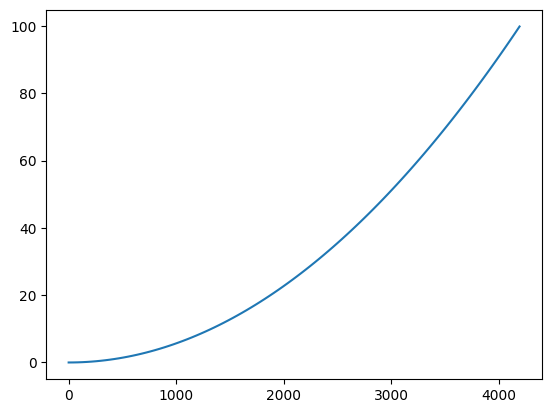

In [73]:
plt.plot(x0, z0)
plt.show()

In [74]:
q0=np.zeros(12*N)

In [75]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [76]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())
 
    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [77]:
root_ = root(static_func, q0, method='df-sane')

In [78]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.203e+02  1.203e+02 ...  0.000e+00  0.000e+00]
       x: [ 2.205e+03  2.248e+03 ...  0.000e+00  0.000e+00]
     nit: 456
    nfev: 1000
  method: df-sane

In [79]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [80]:
# q0 = root_.x                                            # start from static solution

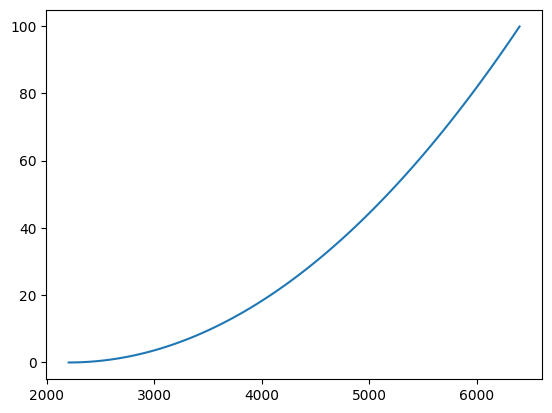

In [81]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [82]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [83]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [84]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [85]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [86]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [87]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [88]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [89]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

#     bc_node = list(range(6))+list(range((len(X)-6),len(X)))
#     bc_val = [0]*6 + vessel_movement
    
    bc_node = list(range(3))+list(range((len(X)-6),len(X)))
    bc_val = [0]*3 + vessel_movement

    vessel_move=np.zeros(len(X)*6)
#     vessel_move[-6:]=vessel_movement

    d,f=FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [90]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [91]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.50446816e-10,  2.29485408e-09, -8.56175575e-10],
       [ 6.38010533e-10,  2.27913688e-10,  1.79295512e-09],
       [ 1.26703981e-09,  1.01190234e-09, -1.41540113e-10],
       [ 1.07334586e-09,  3.81305654e-09,  4.24108748e-10],
       [-1.29875843e-09, -1.38004452e-09, -5.86624083e-11],
       [-1.55341695e-09, -4.98516783e-10, -1.02249942e-09],
       [-4.85670171e-10,  2.35242681e-09, -1.02386366e-09],
       [-2.18574314e-09, -1.80705229e-09,  5.29430721e-10],
       [-2.69119482e-09, -2.82693691e-09,  4.67935024e-10],
       [ 1.03682396e-10, -5.16706677e-10, -1.10981091e-09],
       [-3.14685167e-10,  1.65765057e-09, -2.47837306e-11],
       [ 1.71348802e-09,  6.77573553e-11,  1.94090610e-09],
       [-1.12595444e-09, -7.82279130e-10, -1.02106412e-09],
       [-1.81216819e-10,  3.71699116e-10,  2.00310524e-09],
       [-6.47105480e-10, -2.28309349e-09,  1.03966613e-09],
       [ 2.77615446e+02, -1.66069298e-01

In [92]:
mom

array([[-4.14748291e-10,  9.27797730e-10, -8.73797035e-10],
       [-3.98586053e-10,  1.11867848e-10,  2.56999533e-10],
       [-4.01996658e-10, -1.79318249e-09,  3.05135472e-10],
       [-3.98244993e-10,  2.81943358e-10, -4.28826752e-10],
       [-3.96534361e-10,  3.79964149e-09,  7.26686267e-10],
       [-3.52429197e-10, -2.08092388e-09, -7.20013382e-10],
       [-3.12411430e-10, -8.84297080e-11,  2.25554686e-10],
       [ 9.05743036e-10, -2.85581336e-10,  3.23325366e-10],
       [ 2.58111754e-10,  3.89847266e-10, -5.98447514e-10],
       [ 2.59888111e-10, -1.22781785e-09,  4.23883151e-10],
       [-8.63565219e-10,  1.66187419e-09, -1.47338142e-10],
       [-3.71528586e-10, -2.33376340e-09,  8.04902811e-11],
       [ 6.23501251e-11,  4.96811481e-10,  1.64618541e-10],
       [-1.51658242e-10, -1.62026481e-09, -5.75210990e-10],
       [ 4.01769285e-10,  5.67752068e-10,  6.19365892e-10],
       [-1.05058007e-09, -1.57734240e+02,  1.12578027e+02],
       [-4.33328261e-01, -3.65503183e-11

In [93]:
angle

array([[ 0.03007837, -0.02185333, -0.01178184],
       [ 0.03007834, -0.02119938, -0.01164059],
       [ 0.0300782 , -0.01935112, -0.01121684],
       [ 0.03007786, -0.01653571, -0.01051059],
       [ 0.03007721, -0.01298031, -0.00952184],
       [ 0.03007616, -0.00891207, -0.00825058],
       [ 0.03007459, -0.00455817, -0.00669682],
       [ 0.03007241, -0.00014575, -0.00486055],
       [ 0.03006952,  0.00409801, -0.00274178],
       [ 0.03006581,  0.00794596, -0.0003405 ],
       [ 0.03006118,  0.01117092,  0.00234329],
       [ 0.03005553,  0.01354574,  0.0053096 ],
       [ 0.03004875,  0.01484323,  0.00855842],
       [ 0.03004075,  0.01483622,  0.01208976],
       [ 0.03003142,  0.01329754,  0.01590362],
       [ 0.03002066,  0.01      ,  0.02      ],
       [ 0.03      ,  0.01104993,  0.0198585 ],
       [ 0.03000001,  0.01105006,  0.01985828],
       [ 0.03000001,  0.01105018,  0.01985807],
       [ 0.03000002,  0.0110503 ,  0.01985787],
       [ 0.03000002,  0.01105042,  0.019

### Vessle Simulation

In [94]:
sampleTime = 0.001              # sample time [seconds]
Number = 100000                      # number of samples

In [95]:
Number*sampleTime

100.0

In [96]:
vehicle=semisub('DPcontrol',0.1,-0.1,40.0,0,0)

In [97]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [98]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

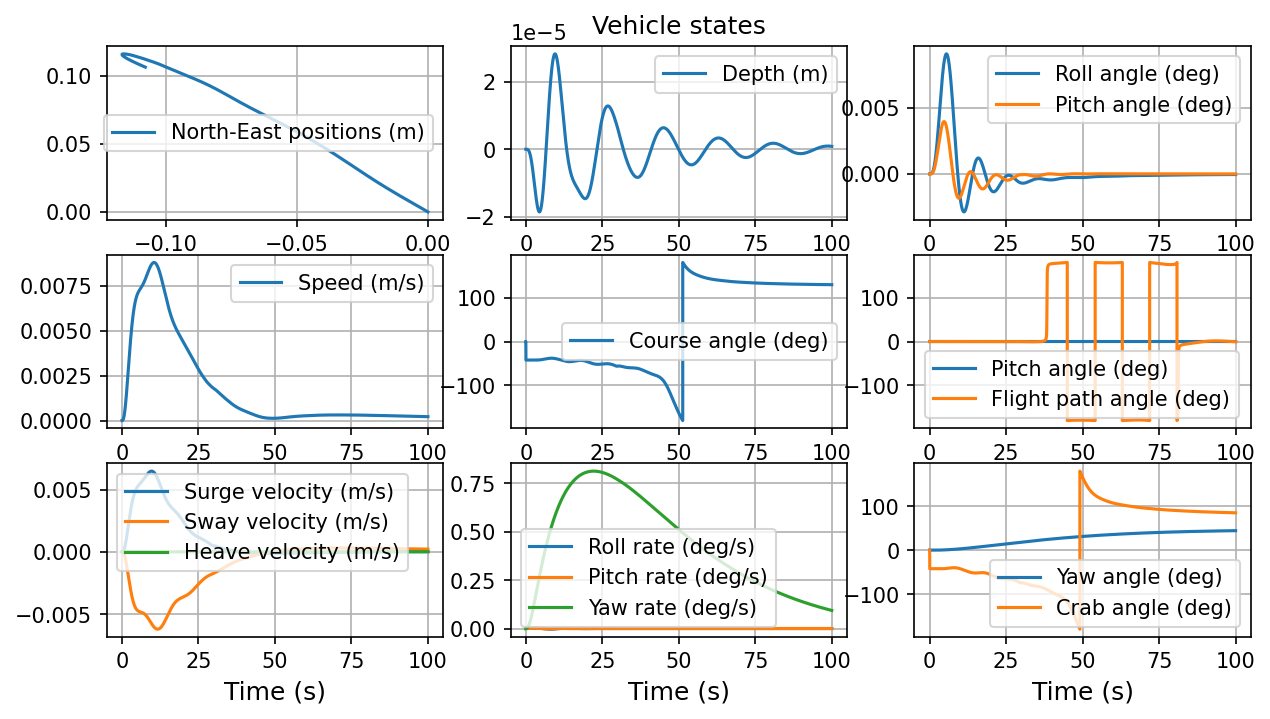

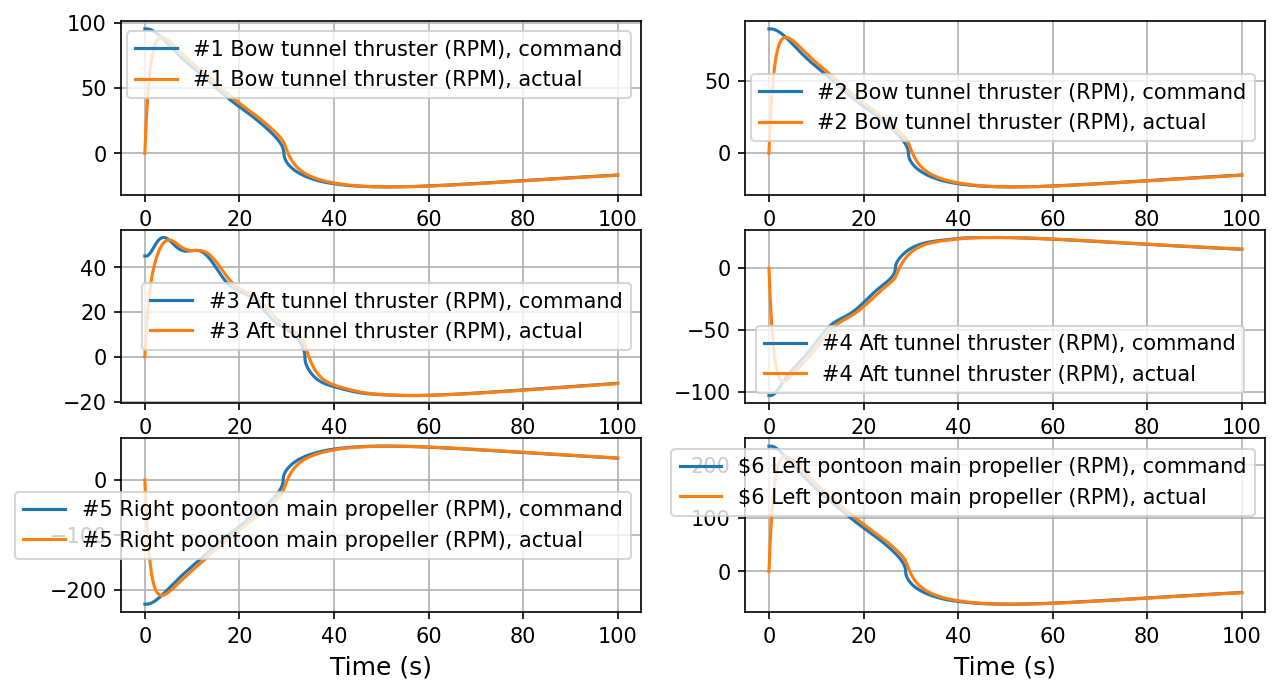

In [99]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [100]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

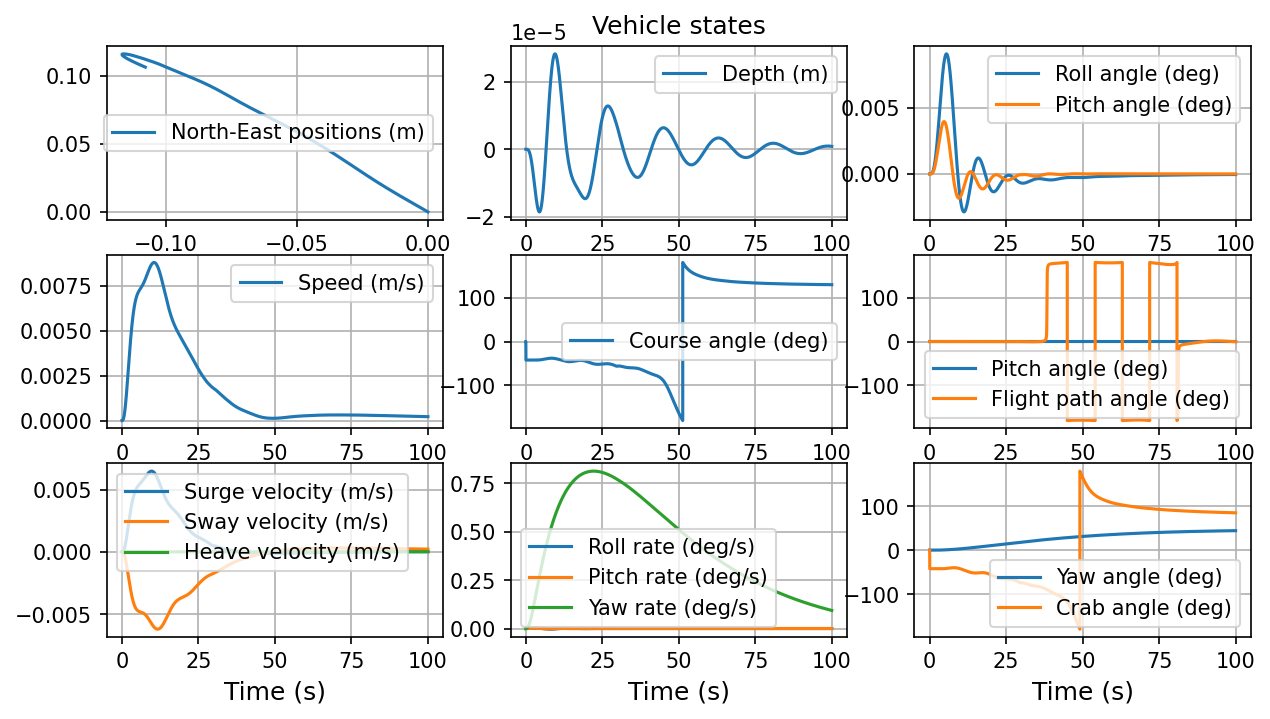

In [101]:
plotVehicleStates(simTime, simData, 3)

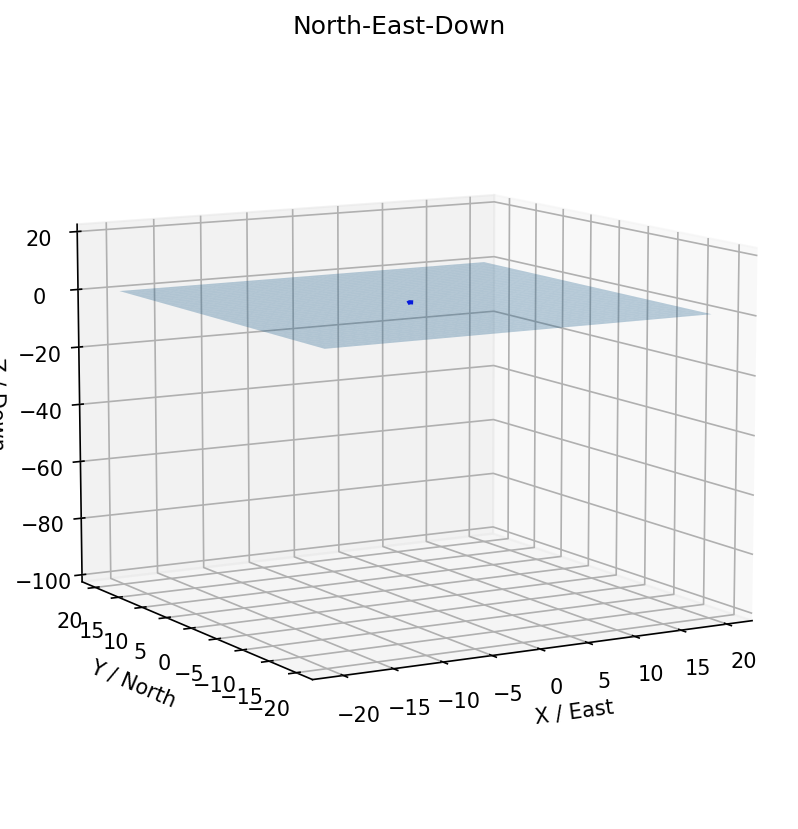

In [102]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [103]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [104]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0

In [105]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [106]:
V_rho=np.zeros(Jrho0.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [107]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [108]:
def dynamic_func(t, Q, coefs, T, calibr):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    del_t = idx-T.my_t
    if del_t<0:
        idx=T.my_t
    
#     print(idx)
    
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
    
#     u_ve = simData[:, 6][idx]
#     v_ve = simData[:, 7][idx]
#     w_ve = simData[:, 8][idx]
#     p_ve = simData[:, 9][idx]
#     q_ve = simData[:, 10][idx]
#     r_ve = simData[:, 11][idx]
    
    
    
   
    
#     x_ve = np.sin(t)
#     y_ve = 1.6*np.sin(t)
#     z_ve = 1.5*np.sin(t)
#     phi_ve = np.cos(3*t)
#     theta_ve = 0.3*np.cos(3*t)
#     psi_ve = 0.5*np.cos(3*t)
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
#     vessel_movement[0] = u_ve *del_t
#     vessel_movement[1] = v_ve*del_t
#     vessel_movement[2] = -w_ve*del_t
#     vessel_movement[3] = p_ve*del_t
#     vessel_movement[4] = q_ve*del_t
#     vessel_movement[5] = r_ve*del_t
    

    
    vessel_movement[0] = (x_ve - T.x_ve)
    vessel_movement[1] = (y_ve - T.y_ve)
    vessel_movement[2] = (z_ve - T.z_ve)
    vessel_movement[3] = np.radians(phi_ve - T.phi_ve)
    vessel_movement[4] = np.radians(theta_ve - T.theta_ve)
    vessel_movement[5] = np.radians(psi_ve - T.psi_ve)
    vessel_movement/=calibr
    

    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    
    Z0 = fors.squeeze()
#     Z0 = np.einsum('ijk,ik->ij', RET, fors) 
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
#     ddx,ddy, ddz = (Z/Ws[0]).T
#     ddx,ddy, ddz = np.einsum('ijk,ik->ij',RET, np.stack([ddx, ddy,ddz], axis=0).T).T  ######?????????
    
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle).squeeze()
#     C0 = np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr', Π(φ,θ,ψ), RET), angle)
    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0)


#     A0 = Jrho(RET,Jrho0)
    A0 = Jrho(RET,Jrho1) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
    
#     ddφ,ddθ,ddψ=np.clip( np.stack([ ddφ,ddθ,ddψ], axis=0), a_min=-1e-5, a_max=1e-5) ######?????????
    
    
#     ddφ,ddθ,ddψ = np.einsum('ijk,ik->ij',RET, np.stack([ ddφ,ddθ,ddψ], axis=0).T).T  ######?????????

#############################################

    T.my_t=idx
    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()
        
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, ddz, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)
    
    return ans

In [109]:
# integration parameters
tspan = (0., 50)
T_ = MyTime()
coefs = [1, 1, 1, 1, 1, 1]

# initial conditions
# q0[6*N+(N-1)], q0[8*N+(N-1)], q0[10*N+(N-1)] = (
#     ssa(simData[:, 3][1000]), ssa(simData[:, 4][1000]), ssa(simData[:, 5][1000]))

q0[6*N:7*N], q0[8*N:9*N], q0[10*N:11*N] = (np.array([0.01 for i in range(N)]),
                                          np.array([0.000001 for i in range(N)]),
                                          np.array([0.000236*i/N for i in range(N)]))


In [110]:
vessel_motion_calibration_coefficient =1

In [111]:
startTime1 = datetime.now()
us_=solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs, T_, vessel_motion_calibration_coefficient,))
print(datetime.now() - startTime1)

Physical time:  0.0006152976260153648  Iteration wall clock time:  0:00:01.091564
Physical time:  1.4793353522490018  Iteration wall clock time:  0:00:07.112234
Physical time:  3.8868592431453037  Iteration wall clock time:  0:00:01.016478
Physical time:  4.243529449204015  Iteration wall clock time:  0:00:00.513718
Physical time:  4.689367206777405  Iteration wall clock time:  0:00:00.468998
Physical time:  5.8030759638005325  Iteration wall clock time:  0:00:00.914948
Physical time:  6.359930342312095  Iteration wall clock time:  0:00:00.541807
Physical time:  9.144202234869915  Iteration wall clock time:  0:00:00.419398
Physical time:  9.639183904657969  Iteration wall clock time:  0:00:00.502043
Physical time:  10.257910991893041  Iteration wall clock time:  0:00:00.566479
Physical time:  10.257910991893041  Iteration wall clock time:  0:00:00.455357
Physical time:  11.474074283562043  Iteration wall clock time:  0:00:00.561091
Physical time:  12.082155929396546  Iteration wall clo

### Results

In [112]:
fin=us_

In [113]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.153e-02 ...  4.760e+01  5.000e+01]
        y: [[ 0.000e+00 -7.711e-19 ... -4.396e-08 -4.839e-08]
            [ 4.237e+01  4.237e+01 ...  4.237e+01  4.237e+01]
            ...
            [ 0.000e+00  7.345e-22 ...  5.111e-09  1.094e-09]
            [ 0.000e+00  7.369e-22 ...  5.111e-09  1.094e-09]]
      sol: None
 t_events: None
 y_events: None
     nfev: 116
     njev: 0
      nlu: 0

In [114]:
t=fin.t

In [115]:
fin=fin.y.T

In [116]:
t.shape, fin.shape

((16,), (16, 1200))

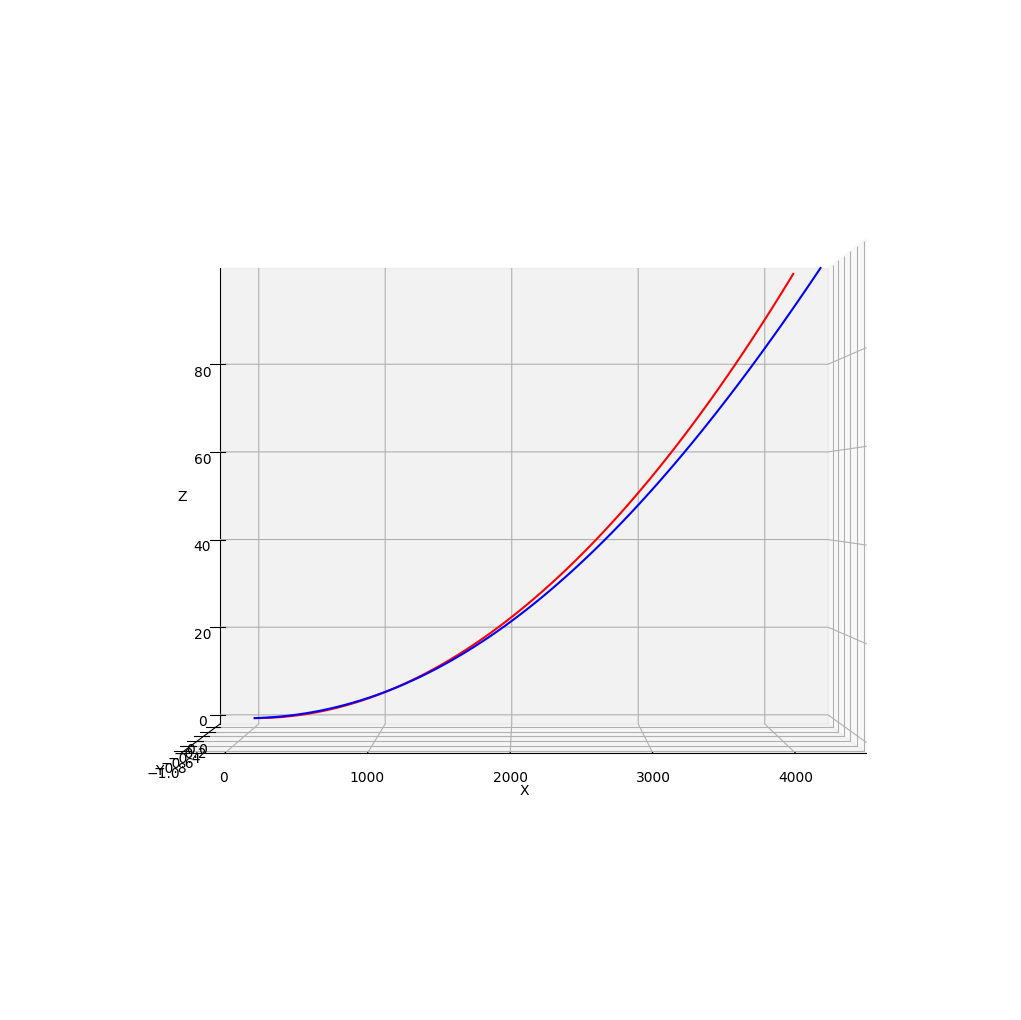

In [117]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [118]:
X,Y,Z

(array([-4.83889816e-08,  4.23660639e+01,  8.47321286e+01,  1.27098194e+02,
         1.69464262e+02,  2.11830331e+02,  2.54196403e+02,  2.96562478e+02,
         3.38928557e+02,  3.81294640e+02,  4.23660728e+02,  4.66026820e+02,
         5.08392919e+02,  5.50759023e+02,  5.93125134e+02,  6.35491252e+02,
         6.77876249e+02,  7.20223512e+02,  7.62589654e+02,  8.04955806e+02,
         8.47321967e+02,  8.89688138e+02,  9.32054320e+02,  9.74420512e+02,
         1.01678672e+03,  1.05915293e+03,  1.10151916e+03,  1.14388540e+03,
         1.18625166e+03,  1.22861793e+03,  1.27098421e+03,  1.31335051e+03,
         1.35571683e+03,  1.39808316e+03,  1.44044950e+03,  1.48281587e+03,
         1.52518225e+03,  1.56754865e+03,  1.60991506e+03,  1.65228150e+03,
         1.69464796e+03,  1.73701443e+03,  1.77938093e+03,  1.82174744e+03,
         1.86411398e+03,  1.90648054e+03,  1.94884712e+03,  1.99121373e+03,
         2.03358036e+03,  2.07594701e+03,  2.11831369e+03,  2.16068039e+03,
         2.2

In [119]:
X0,Y0,Z0

(array([   0.        ,   42.36605322,   84.73210644,  127.09815965,
         169.46421287,  211.83026609,  254.19631931,  296.56237252,
         338.92842574,  381.29447896,  423.66053218,  466.0265854 ,
         508.39263861,  550.75869183,  593.12474505,  635.49079827,
         677.85685149,  720.2229047 ,  762.58895792,  804.95501114,
         847.32106436,  889.68711757,  932.05317079,  974.41922401,
        1016.78527723, 1059.15133045, 1101.51738366, 1143.88343688,
        1186.2494901 , 1228.61554332, 1270.98159653, 1313.34764975,
        1355.71370297, 1398.07975619, 1440.44580941, 1482.81186262,
        1525.17791584, 1567.54396906, 1609.91002228, 1652.27607549,
        1694.64212871, 1737.00818193, 1779.37423515, 1821.74028837,
        1864.10634158, 1906.4723948 , 1948.83844802, 1991.20450124,
        2033.57055446, 2075.93660767, 2118.30266089, 2160.66871411,
        2203.03476733, 2245.40082054, 2287.76687376, 2330.13292698,
        2372.4989802 , 2414.86503342, 2457.23108

In [120]:
us=fin.T

In [121]:
us.shape

(1200, 16)

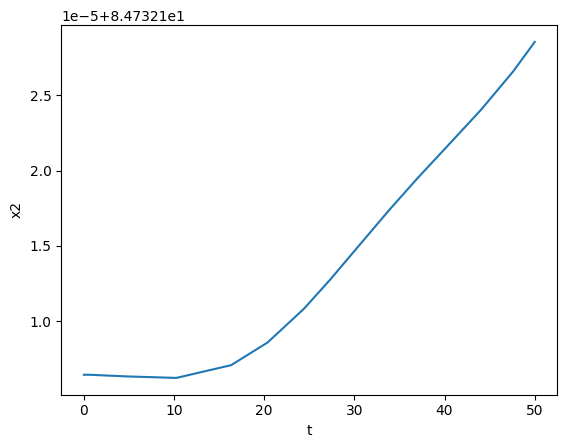

In [122]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

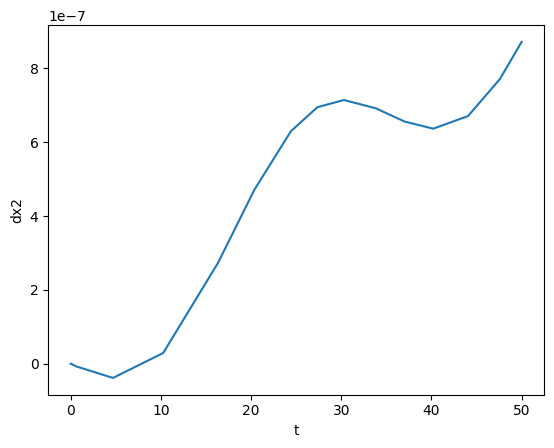

In [123]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

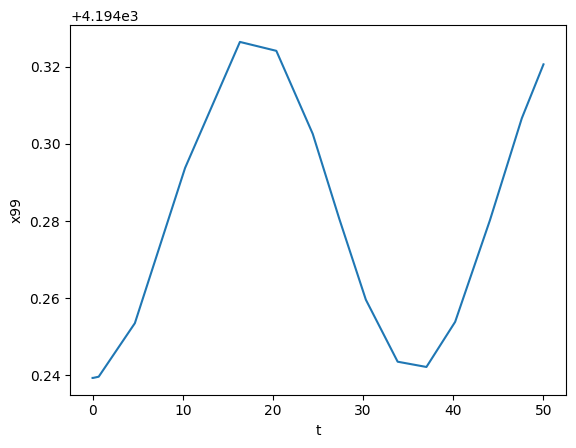

In [124]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

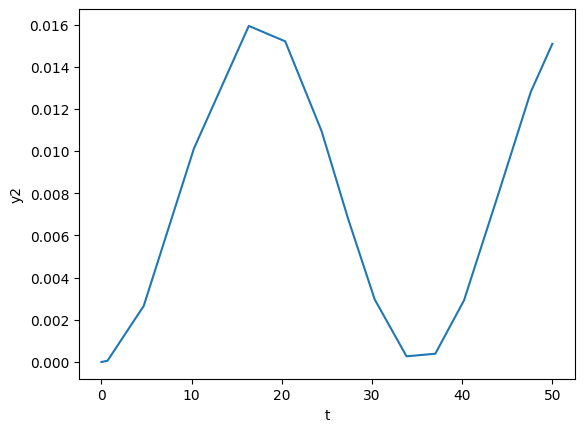

In [125]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

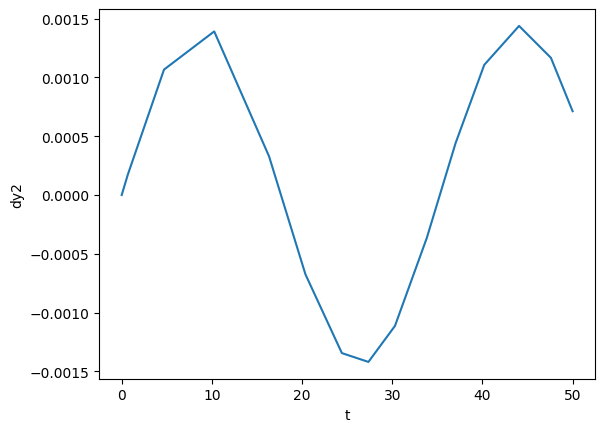

In [126]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

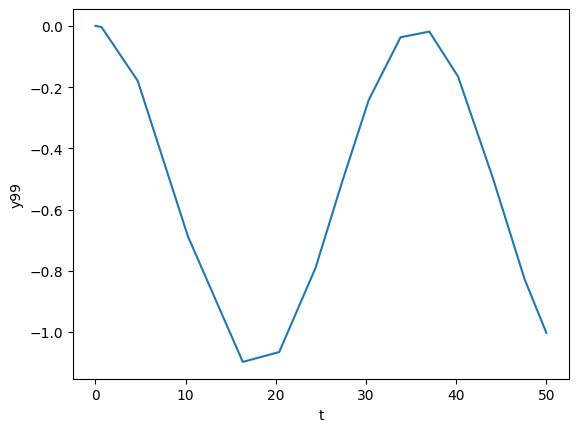

In [127]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

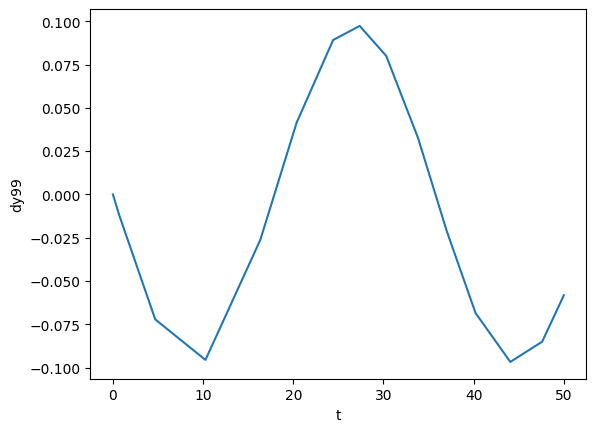

In [128]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

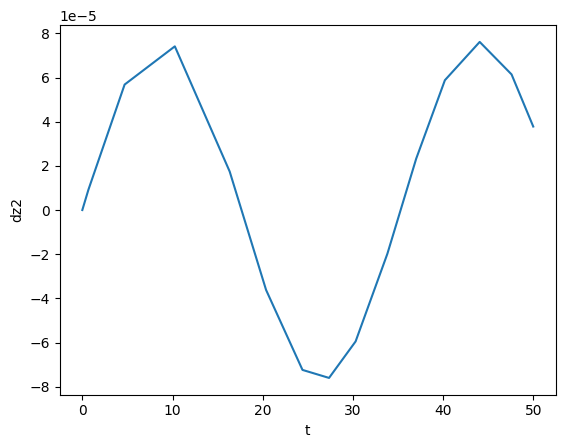

In [129]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

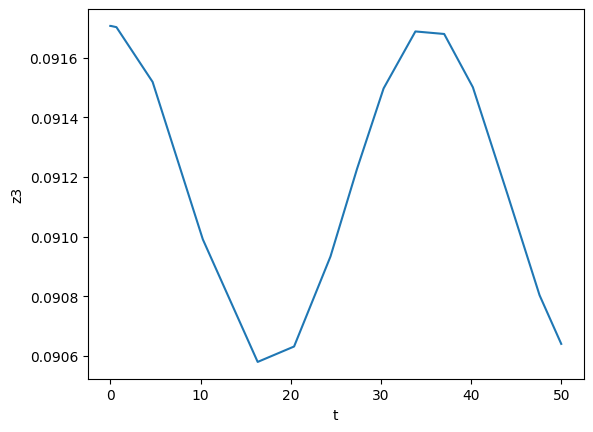

In [130]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

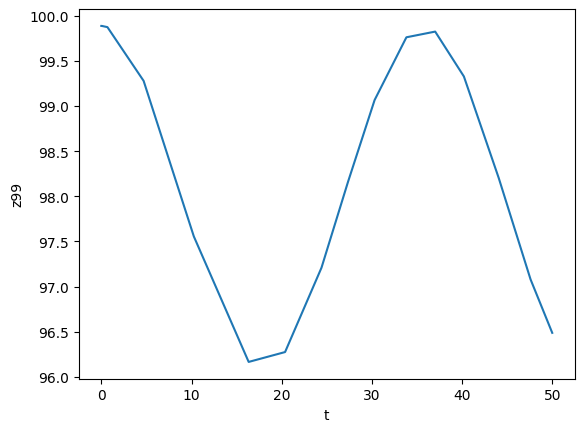

In [131]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

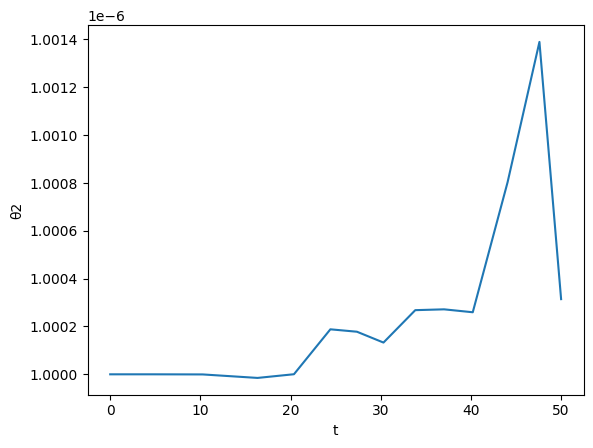

In [132]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

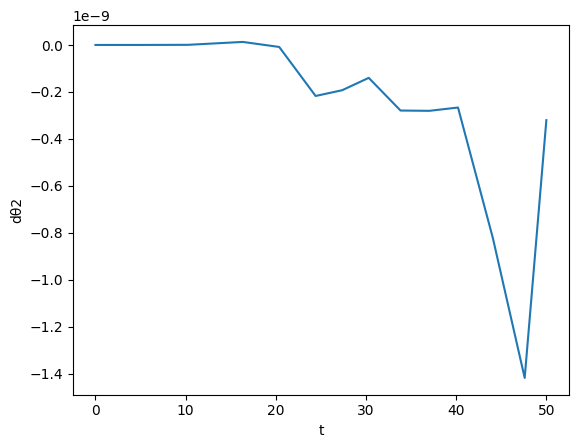

In [133]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

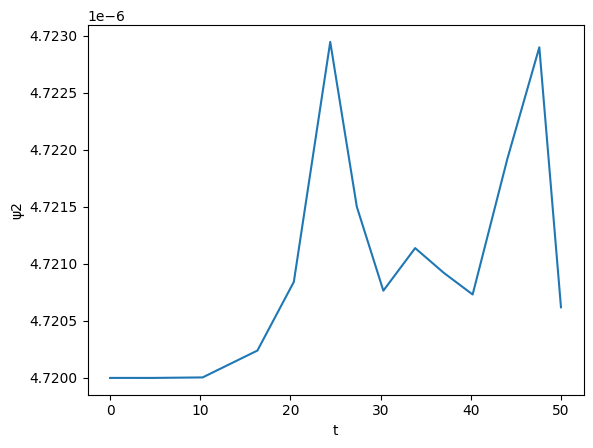

In [134]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

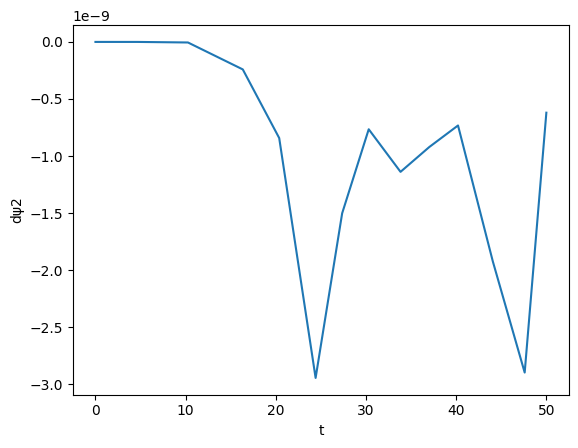

In [135]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

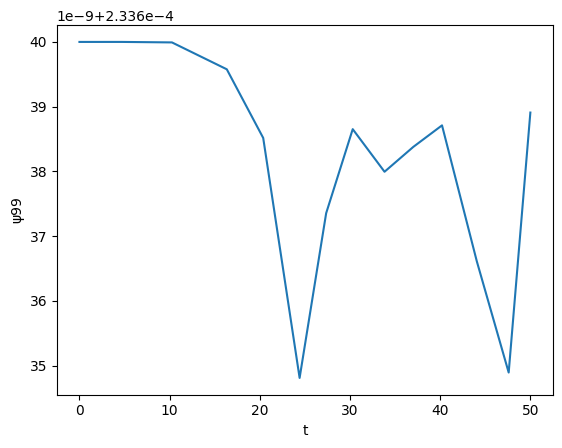

In [136]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()